# Calibration of PS scintillator with two samples:
>only Compton edges visible:
>
>$^{137}$Cs: 477 keV
>   
>$^{22}$Na: 341 keV, 1064 keV

In [1]:
%matplotlib inline

In [2]:
# %load preamb.py
import numpy as np
import pylab as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
import scipy.constants as co
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.signal import argrelextrema as ext
from scipy.signal import savgol_filter as sav
import seaborn as sns
from scipy.special import erfc
from scipy.integrate import quad
import sys

sns.set(style='ticks', palette='Set2')
sns.despine()

fontsize_labels = 22    # size used in latex document
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['figure.figsize'] = (2*6.2, 2*3.83)  # in inches; width corresponds to \textwidth in latex document (golden ratio)

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./data_npy/"


In [3]:
def conv_analytical(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge, x_step, sigma, offset = p
    return A_edge / 2 * erfc((x - x_step) / (np.sqrt(2) * sigma))  + offset

def two_edges(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge1, x_step1, sigma1, A_edge2, x_step2, sigma2, offset = p
    edges = A_edge1 / 2 * erfc((x - x_step1) / (np.sqrt(2) * sigma1)) \
    + A_edge2 / 2 * erfc((x - x_step2) / (np.sqrt(2) * sigma2)) \
    + offset
    return edges

Background
----------------

In [20]:
#### Background ####
file_in = npy_dir + "ps_background_02" + '.npy'
x_bg, y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1, np.sqrt(y_bg)))

t_bg = 56094.804  # Real time
rate_bg = y_bg / t_bg
rate_bg_e = y_bg_e / t_bg

x_lower = 50

$^{22}$Na Sample
----------------

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


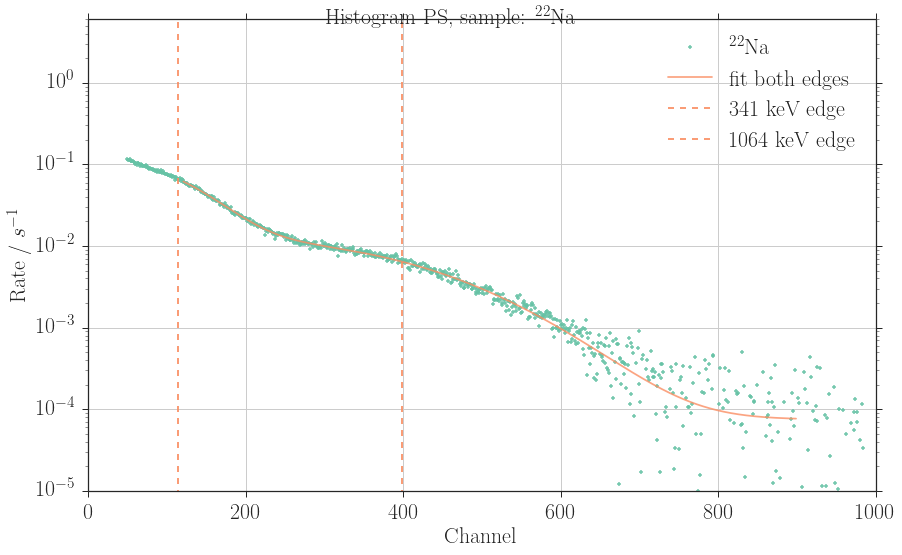

In [21]:
#### 22Na sample ####
na_sample = '$^{22}\mathrm{Na}$'
file_in = npy_dir + "ps_22na_06" + '.npy'
x, y = np.load(file_in)
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

t_na = 59302.371   
rate = y / t_na
rate = rate - rate_bg
rate[rate < 0] = 0
rate[x < x_lower] = 0

rate_e = y_e / t_na - rate_bg_e
rate_e[rate < 0] = 0 
rate_e[x < x_lower] = 0

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e


"""
###### 341 keV COMPTON EDGE #################
# Define range to be fitted
x_min = 120   # lower bound
x_max = 360    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.23, 110, 96,  0.01]
fit_edge0 = conv_analytical(x_fit, *p0)
coeff, cov = curve_fit(conv_analytical, x_fit, y_fit, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
fit_edge = conv_analytical(x_fit, *coeff)
x_step = coeff[1]


###### 1064 keV COMPTON EDGE #################
# Define range to be fitted
x_min = 380   # lower bound
x_max = 900    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit2 = x[mask]
y_fit2 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.015,  440,   130,   1.3e-4]
#fit_edge0 = conv_analytical(x_fit2, *p0)
coeff2, cov2 = curve_fit(conv_analytical, x_fit2, y_fit2, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
fit_edge2 = conv_analytical(x_fit2, *coeff2)
x_step2 = coeff2[1]
"""

###### BOTH COMPTON EDGES #################
# Define range to be fitted
x_min = 120   # lower bound
x_max = 900    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))


# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [0.23, 110, 96, 0.015,  440,   130,   1.3e-4]
#fit_edge0 = two_edges(x_fit, *p0)
coeff, cov = curve_fit(two_edges, x_fit, y_fit, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
c = uc.correlated_values(coeff, cov)
fit_edge = two_edges(x_fit, *coeff)
x_step1 = coeff[1]
x_step2 = coeff[4]


# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram PS, sample: " + na_sample)
#ax1.plot(x, rate_bg, '.', alpha=0.9, label='background')
ax1.plot(x, rate, '.', alpha=0.9, label=(na_sample))
edge, = ax1.plot(x_fit, fit_edge, '-', alpha=0.8, label='fit both edges')
ax1.plot([x_step1] * 2, [0, 8000], '--', c=edge.get_color(), label='341 keV edge')
ax1.plot([x_step2] * 2, [0, 8000], '--', c=edge.get_color(), label='1064 keV edge')
#edge2, = ax1.plot(x_fit2, fit_edge2, '-', alpha=0.8, label='1064 keV edge fit')
#ax1.plot([x_step2] * 2, [0, 8000], '--', c=edge2.get_color(), label='1064 keV edge')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(1e-5, 6)
ax1.legend(loc=1)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


$^{137}$Cs Sample
-----------------

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


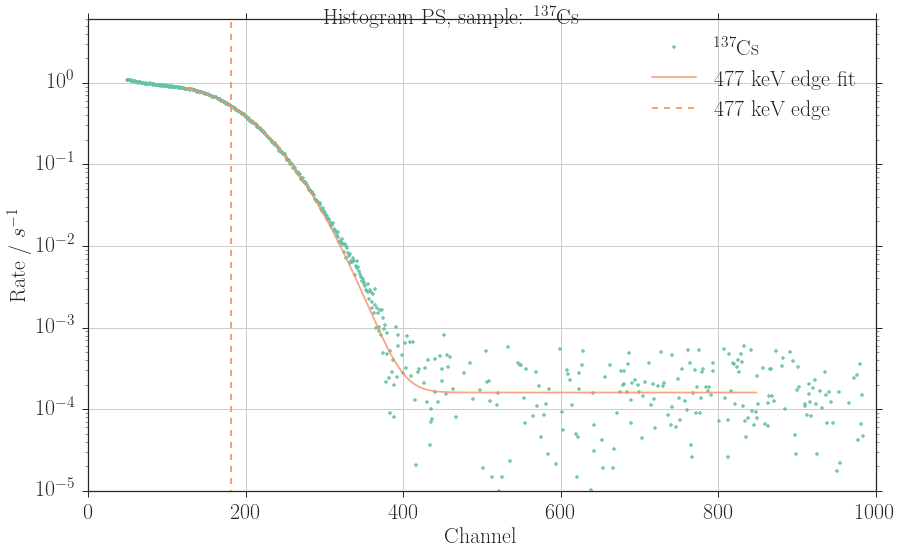

In [22]:
#### 137Cs sample ####
cs_sample = '$^{137}\mathrm{Cs}$'
file_in = npy_dir + "ps_137cs_04" + '.npy'
x, y = np.load(file_in)
y_e = un.uarray(y, np.sqrt(y))

t_ps = 21386.496 # look for data/ps_cs137_04.mcd
rate = y / t_ps
rate = rate - rate_bg
rate[rate < 0] = 0
rate[x < x_lower] = 0

rate_e = y_e / t_ps - rate_bg_e
rate_e[rate < 0] = 0 
rate_e[x < x_lower] = 0

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e


###### 477 keV COMPTON EDGE #################
# Define range to be fitted
x_min = 120   # lower bound
x_max = 850    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.4,  220,   70,   5e-4]
#fit_edge0 = conv_analytical(x_fit3, *p0)
coeff3, cov3 = curve_fit(conv_analytical, x_fit3, y_fit3, p0=p0, 
                              sigma=y_sigma, absolute_sigma=True)
c3 = uc.correlated_values(coeff3, cov3)
fit_edge3 = conv_analytical(x_fit3, *coeff3)
x_step3 = coeff3[1]


# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram PS, sample: "+ cs_sample)
#ax1.plot(x, rate_bg, '.', alpha=0.9, label='background')
ax1.plot(x, rate, '.', alpha=0.9, label=(cs_sample))
edge3, = ax1.plot(x_fit3, fit_edge3, '-', alpha=0.8, label='477 keV edge fit')
ax1.plot([x_step3] * 2, [0, 8000], '--', c=edge3.get_color(), label='477 keV edge')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(1e-5, 6)
ax1.legend(loc=1)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')
if show_fig:
    fig1.show()
if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


### Save parameters

In [18]:
na_compton1 = uc.ufloat(coeff[1], cov[1, 1])
na_compton2 = uc.ufloat(coeff[4], cov[4, 4])
cs_compton  = uc.ufloat(coeff3[1], cov3[1, 1])

# Use sigma for errors!
#na_compton1 = uc.ufloat(coeff[1], coeff[2])
#na_compton2 = uc.ufloat(coeff[4], coeff[5])
#cs_compton  = uc.ufloat(coeff3[1], coeff3[2])

# Calibration by linear fitting
* $^{22}$Na Compton edge 1: 341 keV
* $^{22}$Na Compton edge 2: 1064 keV
* $^{137}$Cs Compton edge: 477 keV

In [19]:
energy = np.array([341, 1064, 477])
fit_results = np.array([c[1], c[4], c3[1]])
channel = un.nominal_values(fit_results)
channel_error = un.std_devs(fit_results)
def linear(x, a, b):
    return (a*x + b)

coeff_lin, cov_lin = curve_fit(linear, energy, channel, p0=None, 
                               sigma=np.sqrt(channel_error), absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)
# Switch to energy(channel):
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'ps_calibration', d_lin)

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


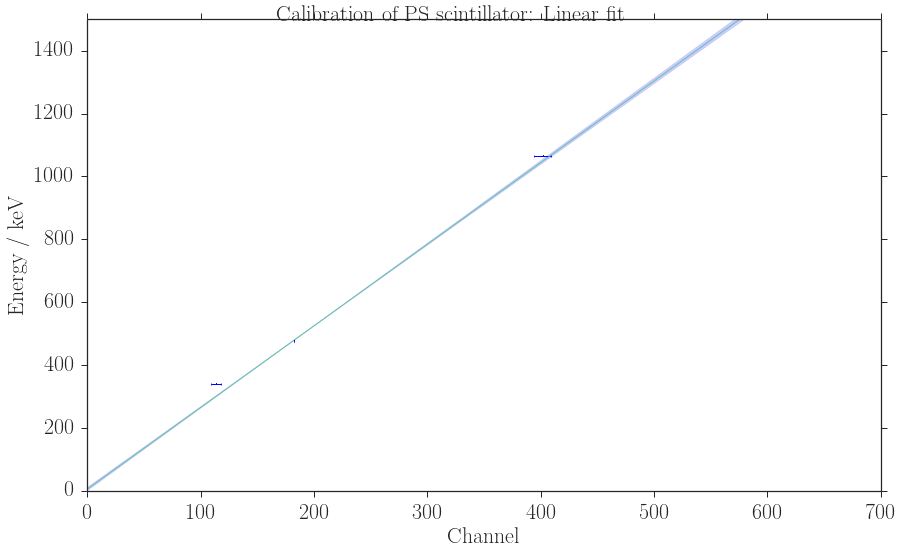

In [9]:
# Plotting
colors = ['b', 'g', 'r', 'pink']
channel_min, channel_max = [0, 700]
chs = np.linspace(channel_min, channel_max, 200)
fit = linear(chs, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Calibration of PS scintillator: Linear fit')
ax1.fill_between(chs, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(chs, un.nominal_values(fit), '-', linewidth=1.0)  

ax1.errorbar(channel, energy, xerr=channel_error, yerr=None, fmt='b,', elinewidth=1.0, capsize=1.2, capthick=0.8)
ax1.set_xlim(channel_min, channel_max)
ax1.set_ylim(0, 1500)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Energy / keV")
#ax1.legend(loc=1)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "calibration_ps_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")